# Акустические модели

Акустическая модель - это часть системы автоматического распознавания речи, которая используется для преобразования аудиосигнала речи в последовательность фонем или других единиц речевого звука. Акустическая модель обучается на большом наборе речевых данных, чтобы определить, какие звуки соответствуют конкретным акустическим признакам в аудиосигнале. Эта модель может использоваться вместе с другими компонентами, такими как языковая модель и модель декодирования, чтобы достичь более точного распознавания речи.

В данной работе мы сконцентрируемся на обучении нейросетевых акустических моделей с помощью библиотек torch и torchaudio. Для экспериментов будем использовать базу [TIMIT](https://catalog.ldc.upenn.edu/LDC93s1)

In [1]:
import numpy as np
import time
import torch
import os
from typing import List, Dict, Union, Set, Any
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import soundfile as sf
import torchaudio
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


/home/karysheva@ad.speechpro.com/miniconda3/envs/ml_labs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузка датасета TIMIT


Официальная страница датасета TIMIT

Для простоты загрузки данных удобнее всего пользоваться копией датасета, выложенной на kaggle

https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech


In [ ]:
!pip install kaggle

In [ ]:
# https://github.com/Kaggle/kaggle-api - Docs kaggle
# Simplest way: go to https://www.kaggle.com/settings , "Create new token" and move it into "~/.kaggle"

!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

Dataset URL: https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech
License(s): copyright-authors
100% 828M/829M [00:37<00:00, 23.9MB/s]
100% 829M/829M [00:37<00:00, 22.9MB/s]


In [ ]:
!unzip -o -q darpa-timit-acousticphonetic-continuous-speech.zip -d timit/

# 1. Подготовка данных для обучения

TIMIT является одной из самых широко используемых баз данных для изучения систем автоматического распознавания речи. База данных TIMIT содержит произнесения предложений различными дикторами. Каждое произнесение сопровождается его словной и фонетической разметкой.

Для обучения акустической модели нам в первую очередь интересна фонетическая разметка произнесений. Такая разметка сопоставляет фонемы, которые были произнесены диктором, с временными интервалами в записи. Такая разметка позволит нам обучить пофреймовый классификатор, который будет предсказывать сказанную фонему.

## 1.a. Загрузка базы с диска

In [2]:
class TimitDataset(Dataset):
    """Загрузка TIMIT данных с диска"""
    def __init__(self, data_path):
        self.data_path = data_path
        self.uri2wav = {}
        self.uri2text = {}
        self.uri2word_ali = {}
        self.uri2phone_ali = {}
        for d, _, fs in os.walk(data_path):
            for f in fs:
                full_path = f'{d}/{f}'
                if f.endswith('.WAV'):
                    # skip it. Use .wav instead
                    pass
                elif f.endswith('.wav'):
                    stem = Path(f[:-4]).stem # .WAV.wav
                    self.uri2wav[f'{d}/{stem}'] = full_path
                elif f.endswith('.TXT'):
                    stem = Path(f).stem
                    self.uri2text[f'{d}/{stem}'] = full_path
                elif f.endswith('.WRD'):
                    stem = Path(f).stem
                    self.uri2word_ali[f'{d}/{stem}'] = full_path
                elif f.endswith('.PHN'):
                    stem = Path(f).stem
                    self.uri2phone_ali[f'{d}/{stem}'] = full_path
                else:
                    warnings.warn(f"Unknown file type {full_path} . Skip it.")

        self.uris = list(sorted(set(self.uri2wav.keys()) \
                                & set(self.uri2text.keys()) \
                                & set(self.uri2word_ali.keys()) \
                                &  set(self.uri2phone_ali.keys())
                               ))
        print(f"Found {len(self.uris)} utterances in {self.data_path}. ",
              f"{len(self.uri2wav)} wavs, ",
              f"{len(self.uri2text)} texts, ",
              f"{len(self.uri2word_ali)} word alinments, ",
             f"{len(self.uri2phone_ali)} phone alignments")

    def get_uri(self, index_or_uri: Union[str, int]):
        if isinstance(index_or_uri, str):
            uri = index_or_uri
        else:
            uri = self.uris[index_or_uri]
        return uri


    def get_audio(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        wav_path = self.uri2wav[uri]
        wav_channels, sr = torchaudio.load(wav_path)
        return wav_channels[0], sr

    def get_text(self, index_or_uri: Union[str, int]):
        """ Return (start_sample, stop_sample, text)"""
        uri = self.get_uri(index_or_uri)
        txt_path = self.uri2text[uri]
        with open(txt_path) as f:
            start, stop, text = f.read().strip().split(maxsplit=2)
            start, stop = int(start), int(stop)
            assert start == 0, f"{txt_path}"
        return start, stop, text

    def get_word_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, word), ...]"""
        uri = self.get_uri(index_or_uri)
        wrd_path = self.uri2word_ali[uri]
        with open(wrd_path) as f:
            words = [(int(start), int(stop), word) for start, stop, word in map(str.split, f.readlines())]
        return words

    def get_phone_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, phone), ...]"""
        uri = self.get_uri(index_or_uri)
        ph_path = self.uri2phone_ali[uri]
        with open(ph_path) as f:
            phonemes = [(int(start), int(stop), ph) for start, stop, ph in map(str.split, f.readlines())]
        return phonemes

    def __getitem__(self, index):
        return {"uri": self.get_uri(index),
                "audio": self.get_audio(index),
                "text": self.get_text(index),
                "word_ali": self.get_word_ali(index),
                "phone_ali": self.get_phone_ali(index)}

    def __len__(self):
        # TODO
        # верните количество элементов в выборке
        return len(self.uris)

    def total_audio_samples(self) -> int:
        #TODO
        # верните суммарное количество отсчетов во всем аудио
        return sum(len(self.get_audio(uri)[0]) for uri in self.uris)

    def total_num_words(self) -> int:
        #TODO
        # верните суммарное количество слов в словном выравнивании
        return sum(len(self.get_word_ali(uri)) for uri in self.uris)

    def total_num_phones(self) -> int:
        #TODO
        # верните суммарное количество фонем в фонемном выравнивании
        return sum(len(self.get_phone_ali(uri)) for uri in self.uris)

    def get_vocab(self) -> Set[str]:
        #TODO
        # верните словарь, состоящий из уникальных слов из выборки
        return {word[2] for uri in self.uris for word in self.get_word_ali(uri)}

    def get_phones(self) -> Set[str]:
        #TODO
        # верните уникальный набор фонем, которые используются в выравнивании
        return {phone[2] for uri in self.uris for phone in self.get_phone_ali(uri)}

    def phones_prior(self) -> Dict[str, float]:
        #TODO
        # верните мапинг фонемы в их априорные вероятности.
        counts = Counter([phone[2] for uri in self.uris for phone in self.get_phone_ali(uri)])
        total = counts.total()
        priors = {key: value / total for key, value in dict(counts).items()}
        return priors


In [3]:
def test_timit_dataset_stats():
    test_ds = TimitDataset('timit/data/TEST/')

    print("Len")
    assert len(test_ds) == 1680, f"{len(test_ds)}"

    print("Audio")
    audio_len = test_ds.total_audio_samples()
    assert audio_len == 82986452, f"{audio_len}"

    print("Words")
    words_len = test_ds.total_num_words()
    assert words_len == 14553, f"{words_len}"

    print("Phones")
    phones_len = test_ds.total_num_phones()
    assert phones_len == 64145, f"{phones_len}"

    print("Vocab")
    vocab = test_ds.get_vocab()
    assert len(set(vocab)) == 2378, f"{len(set(vocab))}"

    print("Phones vocab")
    phones = test_ds.get_phones()
    assert len(set(phones)) == 61, f"{len(set(phones))}"

    print("Phones prior")
    priors = test_ds.phones_prior()
    assert np.isclose(sum(priors.values()), 1.0), f"sum(priors.values())"
    pmin, pmax = min(priors.keys(), key=priors.get), max(priors.keys(), key=priors.get)
    assert pmin == 'eng', pmin
    assert pmax == 'h#', pmax
    print("Test 1.a passed")
test_timit_dataset_stats()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Len
Audio
Words
Phones
Vocab
Phones vocab
Phones prior
Test 1.a passed


In [4]:
test_ds = TimitDataset('timit/data/TEST/')
item = test_ds[5]
print(item['uri'])
print(item['text'][2])
display.display(display.Audio(item['audio'][0].numpy(), rate=item['audio'][1]))
print('---words---')
for start, stop, word in item['word_ali']:
    print(word)
    display.display(display.Audio(item['audio'][0][start:stop].numpy(), rate=item['audio'][1]))
    break

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
timit/data/TEST/DR1/FAKS0/SX133
Pizzerias are convenient for a quick lunch.


---words---
pizzerias


## 1.b. Экстрактор фич
Для того чтобы построить акустическую модель, первым делом надо извлечь признаки аудио сигнала. Для распознавания речь принято использовать fbank признаки. fbank/MelSpectrogram признаки получается из амплитудного спектра сигнала путем свертки спекта с треугольными фильтрами в мел-шкале. Есть множество реализаций данных признаков в различных библиотеках (kaldi, librosa, torchaudio) и все они имеют свои особенности. В данной работе мы будем использовать реализацию из библиотеки torchaudio.

In [5]:
class FeatureExtractor(torch.nn.Module):
    def __init__(
        self,
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        n_mels=40,
        f_max=7600,
        spec_aug_max_fmask=80,
        spec_aug_max_tmask=80,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.f_max = f_max
        self.spec_aug_max_fmask = spec_aug_max_fmask
        self.spec_aug_max_tmask = spec_aug_max_tmask
        #TODO
        # инициализируйте обработчик fbank фич из torchaudio
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels,
            f_max=self.f_max
            )

        self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=self.spec_aug_max_fmask)
        self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=self.spec_aug_max_tmask)

    def samples2frames(self, num_samples: int) -> int:
        # TODO
        # Верните количество кадров в спектрограмме, соответствующей вавке длиной num_samples
        return 1 + num_samples // self.hop_length

    @property
    def feats_dim(self):
        # TODO
        # Верните количество извлекаемых фич
        return self.n_mels

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        mel = self.mel_spec(waveform)
        #mel = self.freq_mask(mel)
        #mel = self.time_mask(mel)
        return mel

In [6]:
def test_samples2frames():
    fe = FeatureExtractor()
    for i in tqdm(range(15000, 40000)):
        wav = torch.zeros(i)
        feats = fe(wav)
        assert feats.shape[-2] == fe.feats_dim, f"{i} {feats.shape[-2]=}, {fe.feats_dim}"

        assert feats.shape[-1] == fe.samples2frames(i), f"{i} {feats.shape[-1]=}, {fe.samples2frames(i)}"

    print('Test 1.b passed')
test_samples2frames()

  4%|▍         | 939/25000 [00:00<00:07, 3293.39it/s]

100%|██████████| 25000/25000 [00:07<00:00, 3166.48it/s]

Test 1.b passed


## 1.с. Таргеты и объединение данных в батчи

Акустическая Модель (АМ) - пофреймовый классификатор, который предсказывает фонему для каждого кадра аудио. Для обучения AM будем использовать фонемное выравнивание.

In [7]:
train_ds = TimitDataset('timit/data/TRAIN/')
print(train_ds[0])

# Строим мапинг из написания фонемы в ее id
phones = train_ds.get_phones()
phones.remove('pau')
phones.remove('epi')
phones.remove('h#')

# Фонемы паузы должны иметь индекс 0
PHONE2ID = {p:i for i, p in enumerate(['pau'] + list(sorted(phones)))}
PHONE2ID['epi'] = 0
PHONE2ID['h#'] = 0
print(PHONE2ID)

Found 4620 utterances in timit/data/TRAIN/.  4620 wavs,  4620 texts,  4620 word alinments,  4620 phone alignments
{'uri': 'timit/data/TRAIN/DR1/FCJF0/SA1', 'audio': (tensor([ 3.0518e-05, -3.0518e-05,  6.1035e-05,  ..., -3.0518e-05,
        -1.5259e-04, -2.4414e-04]), 16000), 'text': (0, 46797, 'She had your dark suit in greasy wash water all year.'), 'word_ali': [(3050, 5723, 'she'), (5723, 10337, 'had'), (9190, 11517, 'your'), (11517, 16334, 'dark'), (16334, 21199, 'suit'), (21199, 22560, 'in'), (22560, 28064, 'greasy'), (28064, 33360, 'wash'), (33754, 37556, 'water'), (37556, 40313, 'all'), (40313, 44586, 'year')], 'phone_ali': [(0, 3050, 'h#'), (3050, 4559, 'sh'), (4559, 5723, 'ix'), (5723, 6642, 'hv'), (6642, 8772, 'eh'), (8772, 9190, 'dcl'), (9190, 10337, 'jh'), (10337, 11517, 'ih'), (11517, 12500, 'dcl'), (12500, 12640, 'd'), (12640, 14714, 'ah'), (14714, 15870, 'kcl'), (15870, 16334, 'k'), (16334, 18088, 's'), (18088, 20417, 'ux'), (20417, 21199, 'q'), (21199, 22560, 'en'), (225

In [8]:
class FeatsPhoneDataset(TimitDataset):
    def __init__(self, data_path, feature_extractor: FeatureExtractor, phone2id):
        super().__init__(data_path)
        self.feature_extractor = feature_extractor
        self.phone2id = phone2id

    def __getitem__(self, index):
        orig_item = super().__getitem__(index)
        wav, sr = orig_item['audio']
        assert sr == self.feature_extractor.sample_rate, f"wrong sr for {index}"
        # подготавливаем пофреймовые фичи
        feats = self.feature_extractor(wav)
        feats = feats.squeeze(dim=0).transpose(0, 1) # time x feats

        # создаем пофреймовое выравнивание
        targets = torch.zeros(feats.shape[0], dtype=torch.long)
        # TODO
        # заполните пофреймовое фонемное выравнивание targets idшниками фонем
        # используйте phone_ali
        for start, end, phone in orig_item["phone_ali"]:
            start_frame = self.feature_extractor.samples2frames(start)
            end_frame = self.feature_extractor.samples2frames(end)
            phone_id = self.phone2id[phone]
            targets[start_frame:end_frame] = phone_id

        return {"uri": orig_item["uri"],
                "feats": feats,
                "targets": targets,
                "src_key_padding_mask": torch.zeros(feats.shape[0], dtype=torch.bool)}

    def collate_pad(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Функция объединения элементов в один батч"""
        # TODO
        # Реализуйте функцию, которая объединяет несколько item'ов датасета в один батч
        # See collate_fn https://pytorch.org/docs/stable/data.html
        # Входные данные и маску надо вернуть таком формате, в каком работает с данными torch.nn.Transformer
        # targets надо склеить тензор с одной осью. Длина оси будет равна суммарному количеству кадров в батче
        
        max_length = max(item["feats"].shape[0] for item in batch)
        feats, targets, src_key_padding_mask = [], [], []

        for item in batch:
            length_to_pad = max_length - item["feats"].shape[0]
            feats.append(torch.cat([item["feats"], torch.zeros(length_to_pad, item["feats"].shape[1])]))
            targets.append(item["targets"])
            padding_mask = torch.cat([torch.zeros(item["feats"].shape[0], dtype=torch.bool), torch.ones(length_to_pad, dtype=torch.bool)])
            src_key_padding_mask.append(padding_mask)

        feats = torch.stack(feats).transpose(0, 1)
        targets = torch.cat(targets)
        src_key_padding_mask = torch.stack(src_key_padding_mask)

        return {'feats': feats, # (Time, Batch, feats)
               'targets': targets, #(SumTime)
               'src_key_padding_mask': src_key_padding_mask, #(Batch, Time)
               }


In [9]:
def test_collate_pad():
    fe = FeatureExtractor()
    test_ds = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)

    for i in range(20):
        targets = test_ds[i]['targets']
        orig_ph_ali = test_ds.get_phone_ali(i)
        targets_set = set(targets.tolist())
        orig_set = set([PHONE2ID[ph] for *_, ph in orig_ph_ali])
        assert targets_set == orig_set, f"{i} \n{targets_set} \n {orig_set} \n {orig_ph_ali}"

    items = [test_ds[i] for i in range(30)]
    batch = test_ds.collate_pad(items)
    assert len(batch['feats'].shape) == 3, batch['feats'].shape
    assert batch['feats'].shape[1] == 30, batch['feats'].shape

    assert len(batch['src_key_padding_mask'].shape) == 2, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[0] == 30, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[1] == batch['feats'].shape[0], f"{batch['feats'].shape} {batch['src_key_padding_mask'].shape}"

    number_nonmasked_frames = (~batch['src_key_padding_mask']).sum()
    assert number_nonmasked_frames == len(batch['targets']), f"{number_nonmasked_frames} != {len(batch['targets'])}"

    accumulated_len = 0
    for i, item in enumerate(items):
        feats = batch['feats'][:, i, :]
        assert torch.isclose(feats.sum(), item['feats'].sum()) , i
        src = batch['src_key_padding_mask'][i, :]
        cutted_feats = feats[~src]
        assert torch.isclose(item['feats'], cutted_feats).all()
        cutted_targets = batch['targets'][accumulated_len: accumulated_len + cutted_feats.shape[0]]
        assert torch.isclose(cutted_targets, item['targets']).all()
        accumulated_len += cutted_feats.shape[0]
    print("Test 1.c passed")

test_collate_pad()


Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Test 1.c passed


# 2. Акустическая модель

Обучим TransformerEncoder из torch решать задачу пофреймовой классификации.

In [10]:
class AModel(nn.Module):
    def __init__(self, feats_dim, out_dim,  dim=128, num_layers=4, ff_dim=256, dropout=0.1, nhead=4, max_len=780):
        super().__init__()
        self.feats_dim = feats_dim
        self.max_len=max_len
        self.input_ff = nn.Linear(feats_dim, dim)
        self.positional_encoding = nn.Embedding(max_len, dim)
        layer = torch.nn.TransformerEncoderLayer(d_model=dim,
                                                 nhead=nhead,
                                                 dim_feedforward=ff_dim,
                                                 dropout=dropout,
                                                 batch_first=False)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=layer, num_layers=num_layers)

        self.head = nn.Linear(dim, out_dim)

    def forward(self, feats, src_key_padding_mask=None, **kwargs):
        #TODO
        # реализуйте прямой проход модели.
        # Фичи подаются на первый ff слой,
        # к результату прибавляются позиционные эмбединги.
        # Далее фреймы обрабатываются трансформером
        # и финализируются с помощью головы
        x = self.input_ff(feats)
        # тензор с индексами позиций во входной последовательности
        positions = torch.arange(0, x.size(0), device=x.device).unsqueeze(1)
        positional_embeddings = self.positional_encoding(positions).expand(-1, x.size(1), -1)
        x = x + positional_embeddings
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        logits = self.head(x)

        return logits # (Time, Batch, Phones)

## 3. Обучение модели

In [40]:
# Стандартный пайплайн обучения моделей в pytorch
class Trainer(nn.Module):
    def __init__(self, model, fe, phone2id, device='cuda', opt_cls=torch.optim.Adam, opt_sch=None, opt_kwargs={'lr':0.0001}, opt_sch_kwargs={}):
        super().__init__()
        self.device=device
        self.fe = fe
        self.model = model.to(self.device)
        self.phone2id = phone2id
        self.id2phone = {i:ph for ph,i in phone2id.items()}
        self.optimizer = opt_cls(self.model.parameters(), **opt_kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.scheduler = opt_sch(self.optimizer, **opt_sch_kwargs) if opt_sch else None
        print(f"{self.model}. {self.device}")

    def to(self, device):
        self.device = device
        return super().to()

    def forward(self, batch):
        batch = self.batch_to_device(batch)
        logits = self.model(**batch)
        # TODO
        # реализуйте подсчет loss функции
        all_preds = []
        for i in range(logits.shape[1]):
            preds = logits[:, i, :]
            mask = batch['src_key_padding_mask'][i, :]
            cutted_preds = preds[~mask]
            all_preds.append(cutted_preds)

        all_preds = torch.cat(all_preds, 0)
        loss = self.criterion(all_preds, batch['targets'])
        return loss

    def batch_to_device(self, batch):
        return {k: v.to(self.device) for k, v in batch.items()}

    def train_one_epoch(self, train_dataloader):
        """ Цикл обучения одной эпохи по всем данным"""
        self.model.train()
        pbar = tqdm(train_dataloader)
        losses = []
        for batch in pbar:
            self.optimizer.zero_grad()
            loss = self.forward(batch)
            loss.backward()
            self.optimizer.step()
            if self.scheduler:
                self.scheduler.step()
            losses.append(loss.item())
            pbar.set_description(f"training loss {losses[-1]:.5f}")
        return losses

    def score(self, valid_dataloader) -> List[float]:
        """Подсчет лосса на валидационной выборке"""
        pbar = tqdm(valid_dataloader, desc="Scoring...")
        losses = []
        # TODO
        # реализуйте функцию, которая подсчитывает лосс на валидационной выборке
        # losses должен хранить значение ошибки на каждом батче
        with torch.no_grad():
            for batch in pbar:
                loss = self.forward(batch)
                losses.append(loss.item())
                pbar.set_description(f"validation loss {losses[-1]:.5f}")
        return losses

    def fit(self, train_dataloader, epochs, valid_dataloader=None, plot_losses=True):
        """Запуск обучения на данном dataloader"""
        pbar = tqdm(range(epochs))
        per_epoch_train_losses = []
        per_epoch_val_losses = []
        for e in pbar:
            train_loss = np.mean(self.train_one_epoch(train_dataloader))
            per_epoch_train_losses.append(train_loss)
            if valid_dataloader is not None:
                val_loss = np.mean(self.score(valid_dataloader))
                per_epoch_val_losses.append(val_loss)
            if plot_losses:
                display.clear_output()
                self.plot_losses(per_epoch_train_losses, per_epoch_val_losses)
            else:
                val_loss = val_loss if valid_dataloader is not None else float('Nan')
                print(f"train: {train_loss:.5f} | val: {val_loss:.5f}")
        return per_epoch_train_losses, per_epoch_val_losses

    def plot_losses(self, train_losses, val_losses=[]):
        plt.title(f"Train test losses (epoch {len(train_losses)})")
        plt.plot(range(len(train_losses)), train_losses)
        if len(val_losses)>0:
            assert len(train_losses) == len(val_losses)
            plt.plot(range(len(val_losses)), val_losses)
        plt.ylabel("loss")
        plt.xlabel('epoch')
        plt.legend(["train loss", "valid loss"])
        plt.grid(True)
        plt.show()

/home/karysheva@ad.speechpro.com/miniconda3/envs/ml_labs/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Found 10 utterances in timit/data/TEST/DR1/FAKS0.  10 wavs,  10 texts,  10 word alinments,  10 phone alignments
AModel(
  (input_ff): Linear(in_features=40, out_features=256, bias=True)
  (positional_encoding): Embedding(780, 256)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=256, out_features=59, bias=True)
).

training loss 4.15340: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


  1%|          | 1/160 [00:00<01:01,  2.58it/s]

train: 4.15340 | val: 3.89363


  1%|▏         | 2/160 [00:00<00:59,  2.66it/s]

train: 3.88998 | val: 3.72027


  2%|▏         | 3/160 [00:01<00:57,  2.74it/s]

train: 3.71538 | val: 3.62899


  2%|▎         | 4/160 [00:01<00:57,  2.69it/s]

train: 3.62382 | val: 3.56735


  3%|▎         | 5/160 [00:01<00:56,  2.72it/s]

train: 3.56212 | val: 3.50760


  4%|▍         | 6/160 [00:02<00:55,  2.75it/s]

train: 3.50238 | val: 3.45723


  4%|▍         | 7/160 [00:02<00:55,  2.77it/s]

train: 3.45227 | val: 3.42319


  5%|▌         | 8/160 [00:02<00:54,  2.79it/s]

train: 3.41869 | val: 3.39945


  6%|▌         | 9/160 [00:03<00:54,  2.77it/s]

train: 3.39535 | val: 3.37679


  6%|▋         | 10/160 [00:03<00:54,  2.77it/s]

train: 3.37288 | val: 3.35200


  7%|▋         | 11/160 [00:03<00:53,  2.79it/s]

train: 3.34807 | val: 3.32671


  8%|▊         | 12/160 [00:04<00:53,  2.79it/s]

train: 3.32260 | val: 3.30371


  8%|▊         | 13/160 [00:04<00:52,  2.78it/s]

train: 3.29939 | val: 3.28431


  9%|▉         | 14/160 [00:05<00:52,  2.80it/s]

train: 3.27981 | val: 3.26714


  9%|▉         | 15/160 [00:05<00:51,  2.80it/s]

train: 3.26260 | val: 3.24947


 10%|█         | 16/160 [00:05<00:51,  2.81it/s]

train: 3.24502 | val: 3.22996


 11%|█         | 17/160 [00:06<00:50,  2.81it/s]

train: 3.22570 | val: 3.20961


 11%|█▏        | 18/160 [00:06<00:51,  2.78it/s]

train: 3.20557 | val: 3.19004


 12%|█▏        | 19/160 [00:06<00:50,  2.80it/s]

train: 3.18621 | val: 3.17135


 12%|█▎        | 20/160 [00:07<00:49,  2.82it/s]

train: 3.16770 | val: 3.15188


 13%|█▎        | 21/160 [00:07<00:48,  2.86it/s]

train: 3.14839 | val: 3.13017


 14%|█▍        | 22/160 [00:07<00:48,  2.87it/s]

train: 3.12685 | val: 3.10629


 14%|█▍        | 23/160 [00:08<00:48,  2.85it/s]

train: 3.10315 | val: 3.08155


 15%|█▌        | 24/160 [00:08<00:48,  2.82it/s]

train: 3.07856 | val: 3.05687


 16%|█▌        | 25/160 [00:08<00:47,  2.81it/s]

train: 3.05401 | val: 3.03191


 16%|█▋        | 26/160 [00:09<00:47,  2.82it/s]

train: 3.02916 | val: 3.00566


 17%|█▋        | 27/160 [00:09<00:47,  2.82it/s]

train: 3.00297 | val: 2.97763


 18%|█▊        | 28/160 [00:10<00:46,  2.82it/s]

train: 2.97500 | val: 2.94837


 18%|█▊        | 29/160 [00:10<00:46,  2.82it/s]

train: 2.94582 | val: 2.91889


 19%|█▉        | 30/160 [00:10<00:46,  2.80it/s]

train: 2.91642 | val: 2.88944


 19%|█▉        | 31/160 [00:11<00:46,  2.75it/s]

train: 2.88701 | val: 2.85942


 20%|██        | 32/160 [00:11<00:46,  2.74it/s]

train: 2.85688 | val: 2.82895


 21%|██        | 33/160 [00:11<00:45,  2.77it/s]

train: 2.82616 | val: 2.79889


 21%|██▏       | 34/160 [00:12<00:45,  2.79it/s]

train: 2.79577 | val: 2.76933


 22%|██▏       | 35/160 [00:12<00:44,  2.80it/s]

train: 2.76588 | val: 2.73977


 22%|██▎       | 36/160 [00:12<00:43,  2.84it/s]

train: 2.73604 | val: 2.70985


 23%|██▎       | 37/160 [00:13<00:42,  2.87it/s]

train: 2.70588 | val: 2.68018


 24%|██▍       | 38/160 [00:13<00:42,  2.90it/s]

train: 2.67592 | val: 2.65080


 24%|██▍       | 39/160 [00:13<00:41,  2.94it/s]

train: 2.64621 | val: 2.62137


 25%|██▌       | 40/160 [00:14<00:43,  2.73it/s]

train: 2.61645 | val: 2.59204


 26%|██▌       | 41/160 [00:14<00:42,  2.81it/s]

train: 2.58687 | val: 2.56331


 26%|██▋       | 42/160 [00:14<00:41,  2.83it/s]

train: 2.55799 | val: 2.53475


 27%|██▋       | 43/160 [00:15<00:41,  2.84it/s]

train: 2.52934 | val: 2.50600


 28%|██▊       | 44/160 [00:15<00:40,  2.84it/s]

train: 2.50056 | val: 2.47737


 28%|██▊       | 45/160 [00:16<00:45,  2.54it/s]

train: 2.47201 | val: 2.44886


 29%|██▉       | 46/160 [00:16<00:42,  2.65it/s]

train: 2.44366 | val: 2.42016


 29%|██▉       | 47/160 [00:16<00:41,  2.75it/s]

train: 2.41518 | val: 2.39153


 30%|███       | 48/160 [00:17<00:39,  2.83it/s]

train: 2.38679 | val: 2.36307


 31%|███       | 49/160 [00:17<00:40,  2.75it/s]

train: 2.35857 | val: 2.33477


 31%|███▏      | 50/160 [00:17<00:39,  2.77it/s]

train: 2.33050 | val: 2.30692


 32%|███▏      | 51/160 [00:18<00:39,  2.77it/s]

train: 2.30282 | val: 2.27928


 32%|███▎      | 52/160 [00:18<00:38,  2.78it/s]

train: 2.27538 | val: 2.25191


 33%|███▎      | 53/160 [00:19<00:38,  2.79it/s]

train: 2.24827 | val: 2.22502


 34%|███▍      | 54/160 [00:19<00:37,  2.80it/s]

train: 2.22167 | val: 2.19840


 34%|███▍      | 55/160 [00:19<00:37,  2.81it/s]

train: 2.19529 | val: 2.17207


 35%|███▌      | 56/160 [00:20<00:37,  2.79it/s]

train: 2.16918 | val: 2.14610


 36%|███▌      | 57/160 [00:20<00:36,  2.80it/s]

train: 2.14347 | val: 2.12027


 36%|███▋      | 58/160 [00:20<00:36,  2.80it/s]

train: 2.11796 | val: 2.09478


 37%|███▋      | 59/160 [00:21<00:35,  2.81it/s]

train: 2.09281 | val: 2.06944


 38%|███▊      | 60/160 [00:21<00:35,  2.79it/s]

train: 2.06775 | val: 2.04429


 38%|███▊      | 61/160 [00:21<00:35,  2.76it/s]

train: 2.04285 | val: 2.01924


 39%|███▉      | 62/160 [00:22<00:35,  2.78it/s]

train: 2.01804 | val: 1.99433


 39%|███▉      | 63/160 [00:22<00:34,  2.78it/s]

train: 1.99338 | val: 1.96966


 40%|████      | 64/160 [00:22<00:34,  2.75it/s]

train: 1.96891 | val: 1.94516


 41%|████      | 65/160 [00:23<00:34,  2.76it/s]

train: 1.94458 | val: 1.92092


 41%|████▏     | 66/160 [00:23<00:33,  2.77it/s]

train: 1.92053 | val: 1.89675


 42%|████▏     | 67/160 [00:24<00:33,  2.79it/s]

train: 1.89656 | val: 1.87276


 42%|████▎     | 68/160 [00:24<00:32,  2.80it/s]

train: 1.87276 | val: 1.84895


 43%|████▎     | 69/160 [00:24<00:32,  2.82it/s]

train: 1.84911 | val: 1.82534


 44%|████▍     | 70/160 [00:25<00:31,  2.84it/s]

train: 1.82563 | val: 1.80179


 44%|████▍     | 71/160 [00:25<00:31,  2.84it/s]

train: 1.80221 | val: 1.77837


 45%|████▌     | 72/160 [00:25<00:30,  2.85it/s]

train: 1.77888 | val: 1.75502


 46%|████▌     | 73/160 [00:26<00:30,  2.86it/s]

train: 1.75560 | val: 1.73174


 46%|████▋     | 74/160 [00:26<00:29,  2.87it/s]

train: 1.73238 | val: 1.70845


 47%|████▋     | 75/160 [00:26<00:29,  2.88it/s]

train: 1.70914 | val: 1.68519


 48%|████▊     | 76/160 [00:27<00:29,  2.87it/s]

train: 1.68594 | val: 1.66206


 48%|████▊     | 77/160 [00:27<00:29,  2.83it/s]

train: 1.66286 | val: 1.63915


 49%|████▉     | 78/160 [00:27<00:28,  2.83it/s]

train: 1.64004 | val: 1.61644


 49%|████▉     | 79/160 [00:28<00:28,  2.82it/s]

train: 1.61746 | val: 1.59390


 50%|█████     | 80/160 [00:28<00:28,  2.81it/s]

train: 1.59506 | val: 1.57146


 51%|█████     | 81/160 [00:28<00:28,  2.81it/s]

train: 1.57277 | val: 1.54914


 51%|█████▏    | 82/160 [00:29<00:27,  2.81it/s]

train: 1.55060 | val: 1.52690


 52%|█████▏    | 83/160 [00:29<00:27,  2.82it/s]

train: 1.52850 | val: 1.50472


 52%|█████▎    | 84/160 [00:30<00:26,  2.83it/s]

train: 1.50647 | val: 1.48262


 53%|█████▎    | 85/160 [00:30<00:26,  2.85it/s]

train: 1.48450 | val: 1.46058


 54%|█████▍    | 86/160 [00:30<00:26,  2.81it/s]

train: 1.46256 | val: 1.43856


 54%|█████▍    | 87/160 [00:31<00:25,  2.82it/s]

train: 1.44061 | val: 1.41660


 55%|█████▌    | 88/160 [00:31<00:25,  2.82it/s]

train: 1.41870 | val: 1.39487


 56%|█████▌    | 89/160 [00:31<00:25,  2.84it/s]

train: 1.39705 | val: 1.37335


 56%|█████▋    | 90/160 [00:32<00:24,  2.84it/s]

train: 1.37563 | val: 1.35201


 57%|█████▋    | 91/160 [00:32<00:24,  2.84it/s]

train: 1.35437 | val: 1.33084


 57%|█████▊    | 92/160 [00:32<00:24,  2.82it/s]

train: 1.33324 | val: 1.30985


 58%|█████▊    | 93/160 [00:33<00:23,  2.82it/s]

train: 1.31230 | val: 1.28907


 59%|█████▉    | 94/160 [00:33<00:23,  2.80it/s]

train: 1.29158 | val: 1.26845


 59%|█████▉    | 95/160 [00:33<00:23,  2.77it/s]

train: 1.27104 | val: 1.24796


 60%|██████    | 96/160 [00:34<00:22,  2.78it/s]

train: 1.25064 | val: 1.22759


 61%|██████    | 97/160 [00:34<00:22,  2.77it/s]

train: 1.23036 | val: 1.20734


 61%|██████▏   | 98/160 [00:35<00:22,  2.76it/s]

train: 1.21021 | val: 1.18721


 62%|██████▏   | 99/160 [00:35<00:22,  2.74it/s]

train: 1.19018 | val: 1.16718


 62%|██████▎   | 100/160 [00:35<00:21,  2.77it/s]

train: 1.17025 | val: 1.14728


 63%|██████▎   | 101/160 [00:36<00:20,  2.81it/s]

train: 1.15046 | val: 1.12750


 64%|██████▍   | 102/160 [00:36<00:20,  2.84it/s]

train: 1.13077 | val: 1.10784


 64%|██████▍   | 103/160 [00:36<00:20,  2.83it/s]

train: 1.11120 | val: 1.08833


 65%|██████▌   | 104/160 [00:37<00:19,  2.82it/s]

train: 1.09178 | val: 1.06901


 66%|██████▌   | 105/160 [00:37<00:19,  2.81it/s]

train: 1.07256 | val: 1.05009


 66%|██████▋   | 106/160 [00:37<00:19,  2.83it/s]

train: 1.05375 | val: 1.03250


 67%|██████▋   | 107/160 [00:38<00:18,  2.85it/s]

train: 1.03635 | val: 1.01809


 68%|██████▊   | 108/160 [00:38<00:18,  2.87it/s]

train: 1.02232 | val: 1.00501


 68%|██████▊   | 109/160 [00:38<00:17,  2.88it/s]

train: 1.00964 | val: 0.97831


 69%|██████▉   | 110/160 [00:39<00:17,  2.89it/s]

train: 0.98234 | val: 0.96083


 69%|██████▉   | 111/160 [00:39<00:16,  2.89it/s]

train: 0.96498 | val: 0.94827


 70%|███████   | 112/160 [00:39<00:16,  2.85it/s]

train: 0.95264 | val: 0.92397


 71%|███████   | 113/160 [00:40<00:16,  2.85it/s]

train: 0.92802 | val: 0.91222


 71%|███████▏  | 114/160 [00:40<00:16,  2.86it/s]

train: 0.91656 | val: 0.89343


 72%|███████▏  | 115/160 [00:40<00:15,  2.85it/s]

train: 0.89773 | val: 0.87511


 72%|███████▎  | 116/160 [00:41<00:15,  2.85it/s]

train: 0.87926 | val: 0.86180


 73%|███████▎  | 117/160 [00:41<00:15,  2.83it/s]

train: 0.86625 | val: 0.84088


 74%|███████▍  | 118/160 [00:42<00:14,  2.82it/s]

train: 0.84495 | val: 0.82794


 74%|███████▍  | 119/160 [00:42<00:14,  2.78it/s]

train: 0.83220 | val: 0.80890


 75%|███████▌  | 120/160 [00:42<00:14,  2.80it/s]

train: 0.81294 | val: 0.79464


 76%|███████▌  | 121/160 [00:43<00:13,  2.82it/s]

train: 0.79882 | val: 0.77837


 76%|███████▋  | 122/160 [00:43<00:13,  2.82it/s]

train: 0.78238 | val: 0.76221


 77%|███████▋  | 123/160 [00:43<00:13,  2.83it/s]

train: 0.76619 | val: 0.74771


 78%|███████▊  | 124/160 [00:44<00:12,  2.80it/s]

train: 0.75174 | val: 0.73070


 78%|███████▊  | 125/160 [00:44<00:12,  2.83it/s]

train: 0.73456 | val: 0.71700


 79%|███████▉  | 126/160 [00:44<00:12,  2.82it/s]

train: 0.72090 | val: 0.70047


 79%|███████▉  | 127/160 [00:45<00:11,  2.82it/s]

train: 0.70423 | val: 0.68673


 80%|████████  | 128/160 [00:45<00:11,  2.82it/s]

train: 0.69055 | val: 0.67128


 81%|████████  | 129/160 [00:45<00:10,  2.83it/s]

train: 0.67497 | val: 0.65686


 81%|████████▏ | 130/160 [00:46<00:10,  2.76it/s]

train: 0.66053 | val: 0.64266


 82%|████████▏ | 131/160 [00:46<00:10,  2.78it/s]

train: 0.64628 | val: 0.62777


 82%|████████▎ | 132/160 [00:47<00:10,  2.80it/s]

train: 0.63127 | val: 0.61438


 83%|████████▎ | 133/160 [00:47<00:09,  2.82it/s]

train: 0.61788 | val: 0.59964


 84%|████████▍ | 134/160 [00:47<00:09,  2.81it/s]

train: 0.60303 | val: 0.58639


 84%|████████▍ | 135/160 [00:48<00:08,  2.82it/s]

train: 0.58976 | val: 0.57249


 85%|████████▌ | 136/160 [00:48<00:08,  2.81it/s]

train: 0.57579 | val: 0.55885


 86%|████████▌ | 137/160 [00:48<00:08,  2.82it/s]

train: 0.56206 | val: 0.54588


 86%|████████▋ | 138/160 [00:49<00:07,  2.82it/s]

train: 0.54905 | val: 0.53227


 87%|████████▋ | 139/160 [00:49<00:07,  2.82it/s]

train: 0.53532 | val: 0.51964


 88%|████████▊ | 140/160 [00:49<00:07,  2.83it/s]

train: 0.52266 | val: 0.50677


 88%|████████▊ | 141/160 [00:50<00:06,  2.83it/s]

train: 0.50970 | val: 0.49407


 89%|████████▉ | 142/160 [00:50<00:06,  2.83it/s]

train: 0.49693 | val: 0.48195


 89%|████████▉ | 143/160 [00:50<00:06,  2.83it/s]

train: 0.48479 | val: 0.46958


 90%|█████████ | 144/160 [00:51<00:05,  2.84it/s]

train: 0.47233 | val: 0.45772


 91%|█████████ | 145/160 [00:51<00:05,  2.84it/s]

train: 0.46044 | val: 0.44606


 91%|█████████▏| 146/160 [00:51<00:04,  2.84it/s]

train: 0.44874 | val: 0.43438


 92%|█████████▏| 147/160 [00:52<00:04,  2.84it/s]

train: 0.43700 | val: 0.42314


 92%|█████████▎| 148/160 [00:52<00:04,  2.83it/s]

train: 0.42574 | val: 0.41200


 93%|█████████▎| 149/160 [00:53<00:03,  2.83it/s]

train: 0.41457 | val: 0.40104


 94%|█████████▍| 150/160 [00:53<00:03,  2.82it/s]

train: 0.40357 | val: 0.39056


 94%|█████████▍| 151/160 [00:53<00:03,  2.82it/s]

train: 0.39305 | val: 0.38051


 95%|█████████▌| 152/160 [00:54<00:02,  2.82it/s]

train: 0.38304 | val: 0.37084


 96%|█████████▌| 153/160 [00:54<00:02,  2.82it/s]

train: 0.37339 | val: 0.36190


 96%|█████████▋| 154/160 [00:54<00:02,  2.84it/s]

train: 0.36465 | val: 0.35233


 97%|█████████▋| 155/160 [00:55<00:01,  2.84it/s]

train: 0.35507 | val: 0.34234


 98%|█████████▊| 156/160 [00:55<00:01,  2.84it/s]

train: 0.34489 | val: 0.33136


 98%|█████████▊| 157/160 [00:55<00:01,  2.84it/s]

train: 0.33356 | val: 0.32225


 99%|█████████▉| 158/160 [00:56<00:00,  2.83it/s]

train: 0.32447 | val: 0.31503


 99%|█████████▉| 159/160 [00:56<00:00,  2.76it/s]

train: 0.31734 | val: 0.30585


100%|██████████| 160/160 [00:56<00:00,  2.81it/s]


train: 0.30803 | val: 0.29604


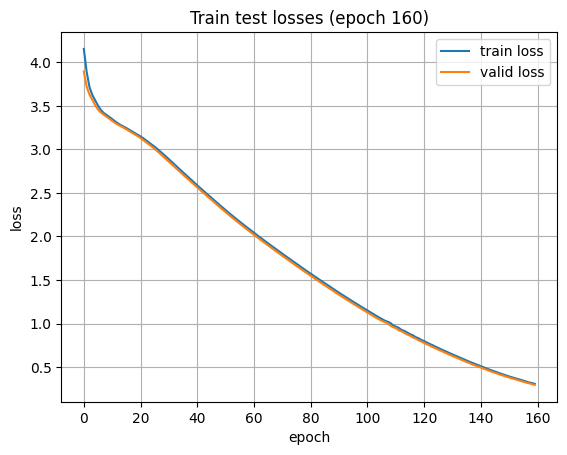

validation loss 0.30347: 100%|██████████| 10/10 [00:00<00:00, 66.94it/s]

Test 3.a passed


In [21]:
def overfit_one_batch_check():
    # Для проверки работоспособности кода обучения удоно использовать тест модели на overfit
    # Для этого запускается обучение на одном батче данных.
    # Если код написан правильно, то модель обязана выучить выучить все примеры из этого батча наизусть.
    fe = FeatureExtractor()
    train_dataset = FeatsPhoneDataset('timit/data/TEST/DR1/FAKS0', feature_extractor=fe, phone2id=PHONE2ID)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_pad)
    test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate_pad)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim,
                                   out_dim=max(PHONE2ID.values()) + 1,
                                   dim=256,
                                   num_layers=6,
                                   ff_dim=512,
                                   dropout=0.0,
                                   nhead=8),
                      fe=fe,
                      phone2id=PHONE2ID, device='cuda')

    # only one batch. The model must learn it by heart
    losses, val_losses = trainer.fit(train_dataloader, 160, valid_dataloader=test_dataloader, plot_losses=False)

    trainer.plot_losses(losses, val_losses)

    val_loss = np.mean(trainer.score(test_dataloader))

    assert val_loss < 0.5, f"{val_loss}. Model doesn't train well"
    print(f"Test 3.a passed")
overfit_one_batch_check()

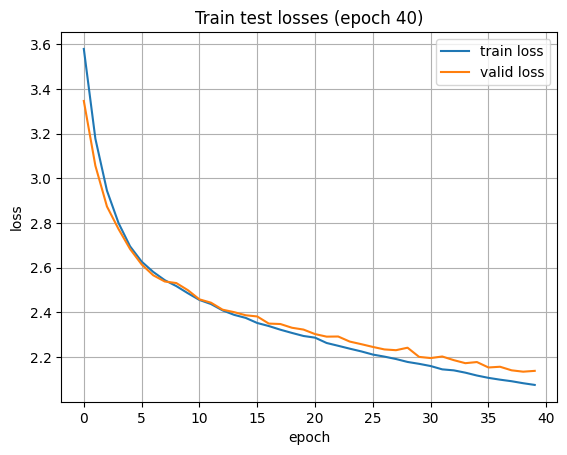

100%|██████████| 40/40 [1:06:17<00:00, 99.43s/it] 


In [29]:
def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=40,
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)


    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim,
                                 out_dim=max(PHONE2ID.values())+1,
                                 dim=128,
                                 num_layers=7,
                                 ff_dim=256,
                                 dropout=0.0,
                                 nhead=8),
                     fe=fe,
                     phone2id=PHONE2ID, device='cuda')

    trainer.fit(train_dataloader, epochs=40, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu')
results = experiment()

In [30]:
torch.save(results, 'baseline.trainer')

# Основное задание (12 баллов)
Надо улучшить бейзлайн так, чтобы значение loss на валидации было менее 1.9

**Дополнительное задание** (4 балла): Улучшите loss до 1.4

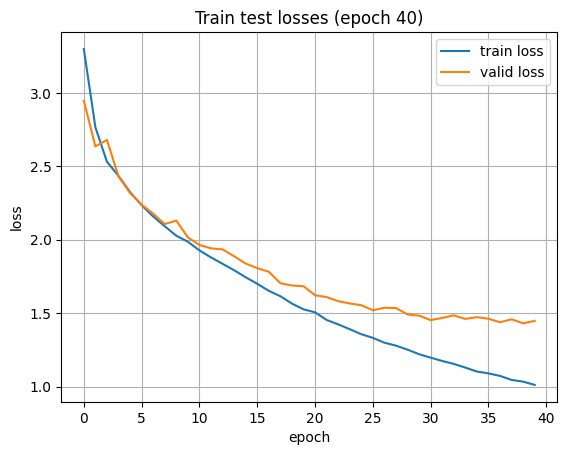

100%|██████████| 40/40 [1:00:57<00:00, 91.44s/it]


In [31]:
def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)


    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim,
                                 out_dim=max(PHONE2ID.values())+1,
                                 dim=128,
                                 num_layers=7,
                                 ff_dim=256,
                                 dropout=0.0,
                                 nhead=8),
                     fe=fe,
                     opt_cls=torch.optim.AdamW,
                     opt_kwargs={'lr': 0.001, 'weight_decay': 0.01},
                     phone2id=PHONE2ID, device='cuda')

    trainer.fit(train_dataloader, epochs=40, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu')
results = experiment()

In [32]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.8, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.3:
        print(f"Additional task is done! (+4 points)")
test_trained_model(results.to('cuda'))

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments


validation loss 2.05141: 100%|██████████| 1680/1680 [00:24<00:00, 67.42it/s]

Test loss is 1.4423651957440944
Main task is done! (12 points)


In [34]:
torch.save(results, 'adamw_model.trainer')

In [ ]:
from transformers.optimization import Adafactor
from lion_pytorch import Lion

In [58]:
trained_model = torch.load('adamw_model.trainer')

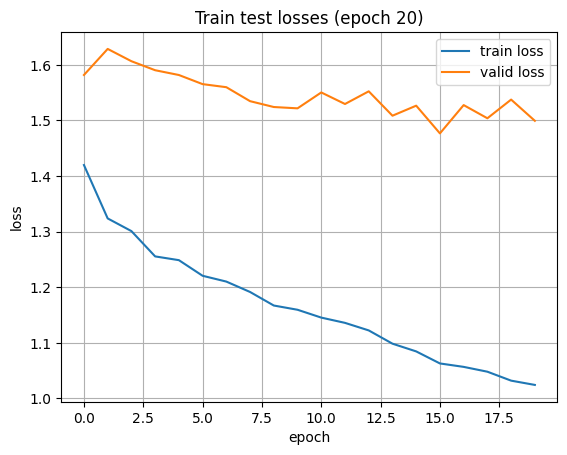

100%|██████████| 20/20 [32:36<00:00, 97.83s/it]


In [ ]:
def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)

    trained_model.optimizer = Adafactor(trained_model.parameters(), scale_parameter=False, relative_step=False, warmup_init=False, lr=1e-3)
    trained_model.fit(train_dataloader, epochs=20, valid_dataloader=test_dataloader, plot_losses=True)
    return trained_model.to('cpu')
adafactor_results = experiment()

In [61]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.8, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.3:
        print(f"Additional task is done! (+4 points)")
test_trained_model(adafactor_results.to('cuda'))

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments


validation loss 0.79793:   0%|          | 0/1680 [00:00<?, ?it/s]

validation loss 1.95801: 100%|██████████| 1680/1680 [00:23<00:00, 70.12it/s]

Test loss is 1.4993623036713828
Main task is done! (12 points)


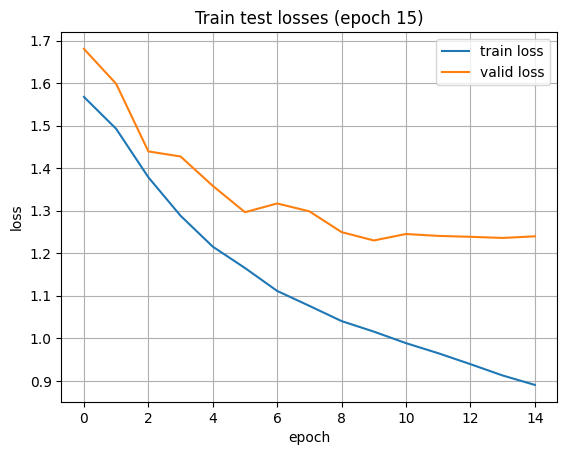

100%|██████████| 15/15 [24:32<00:00, 98.18s/it]


In [ ]:
trained_model = torch.load('adamw_model.trainer')
def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)

    trained_model.optimizer = Lion(trained_model.parameters(), lr=1e-3, weight_decay=1e-2)
    trained_model.fit(train_dataloader, epochs=15, valid_dataloader=test_dataloader, plot_losses=True)
    return trained_model.to('cpu')
lion_results = experiment()

In [63]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.8, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.3:
        print(f"Additional task is done! (+4 points)")
test_trained_model(lion_results.to('cuda'))

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments


validation loss 0.92905:   0%|          | 0/1680 [00:00<?, ?it/s]

validation loss 1.56968: 100%|██████████| 1680/1680 [00:25<00:00, 67.10it/s]

Test loss is 1.2396672971724045
Main task is done! (12 points)
Additional task is done! (+4 points)
